This notebook looks at the effect varying the number of candidates as we increase the number of ballots. 
Let's pick k = 1000 (the spacing between the ballots before we pick it)

In [1]:
# adjust the directory so that we can import local source
import sys
import os

# Add the repo root to sys.path
ROOT_REL_PATH_FROM_NB = "../.."
repo_path = os.path.abspath(os.path.join(os.getcwd(), ROOT_REL_PATH_FROM_NB))  # adjust as needed
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

print(sys.path)

from src.votekit.ballot_generator import name_BradleyTerry 
from src.votekit.pref_interval import PreferenceInterval
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

['/Users/ppeaungvongpakdy/Documents/Research/votekit_bt/VoteKit', '/Users/ppeaungvongpakdy/miniforge3/lib/python312.zip', '/Users/ppeaungvongpakdy/miniforge3/lib/python3.12', '/Users/ppeaungvongpakdy/miniforge3/lib/python3.12/lib-dynload', '', '/Users/ppeaungvongpakdy/miniforge3/lib/python3.12/site-packages', '/Users/ppeaungvongpakdy/choix']


In [2]:
## run both classic and both types of MCMC runs for maybe 1k, 5k, 10k ballots with various n and see how they compare
## might be worth writing a method to generate data for $n$ candidates so that we can scale $n$ easily
def generate_BT_args(n_cands, alpha=1):
    '''
        generates arguments for name_BradleyTerry with n_cands,
        generates single slate and single bloc, 
    '''
    # num cands goes up to 26
    cands = [chr(ord('a')+i) for i in range(n_cands)]
    bloc_name = "H"
    pref_interval = PreferenceInterval.from_dirichlet(candidates=cands, alpha=alpha)
    pref_intervals_by_bloc = {
        bloc_name: {
            bloc_name : pref_interval
        }
    }
    bloc_voter_prop = {bloc_name: 1}
    cohesion_paramteters = {
        bloc_name: {
            bloc_name: 1
        }
    }
    
    return {
        "candidates": cands,
        "pref_intervals_by_bloc": pref_intervals_by_bloc,
        "bloc_voter_prop" : bloc_voter_prop,
        "cohesion_parameters": cohesion_paramteters
    }


def total_variation_distance(P, Q, labels):
    sum = 0 
    for x in labels:
        sum += abs(P[x] - Q[x])
    return (1/2)*sum
    
#bt_args = generate_BT_args(5, alpha=1)
#dummy_method(**bt_args)
#test_BT = name_BradleyTerry(**bt_args)

In [8]:
def tv_per_experiment(num_ballots, n_cands, num_trials):
    ## Intialize voters and number of candidates ----------------------------
    bt = name_BradleyTerry(**generate_BT_args(n_cands=n_cands, alpha=1))

    running_total = []
    for _ in range(num_trials): 
        bals_BT_classic = bt.generate_profile(num_ballots).group_ballots()
        bals_BT_MCMC_evenly_spaced = bt.generate_profile_MCMC_evenly_spaced(num_ballots, SPACING_LENGTH, verbose=False, on_shortcut_graph=False).group_ballots()
    
        ballot_rankings_classic = [bal.ranking for bal in bals_BT_classic.ballots]
        bal_labels_classic = ["".join([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings_classic]
        bal_weights_classic = [int(bal.weight) for bal in bals_BT_classic.ballots]
    
        ballot_rankings_evenly_spaced = [bal.ranking for bal in bals_BT_MCMC_evenly_spaced.ballots]
        bal_labels_evenly_spaced = ["".join([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings_evenly_spaced]
        bal_weights_evenly_spaced = [int(bal.weight) for bal in bals_BT_MCMC_evenly_spaced.ballots]

        # map ballots to weights for each method
        bal_rankings_map_classic = {bal_labels_classic[i]: bal_weights_classic[i]/num_ballots for i in range(len(ballot_rankings_classic))}
        bal_rankings_map_MCMC_evenly_spaced = {bal_labels_evenly_spaced[i]: bal_weights_evenly_spaced[i]/num_ballots for i in range(len(ballot_rankings_evenly_spaced))}
        
        all_keys = [list(m.keys()) for m in [
            bal_rankings_map_classic, bal_rankings_map_MCMC_evenly_spaced
        ]]
        flattened_keys = [k for sublist in all_keys for k in sublist]
        
        for key in flattened_keys:
            bal_rankings_map_classic.setdefault(key, 0) 
            bal_rankings_map_MCMC_evenly_spaced.setdefault(key, 0)
        
        all_keys = list(set(bal_rankings_map_classic) | set(bal_rankings_map_MCMC_evenly_spaced))
        
        running_total.append(total_variation_distance(bal_rankings_map_MCMC_evenly_spaced, bal_rankings_map_classic, all_keys))
        # TODO: Replace the append with a numerical result
    return np.mean(running_total)

In [13]:
num_ballots = 1000
n_cands = 5 
num_trials = 1
number_ballots = [10, 100, 1000, 10000]
number_candidates = [i for i in range(3,12)]
SPACING_LENGTH = 1000

In [ ]:
## FIX n_cands = 5 and loop thorugh number_ballots as preliminary result

In [20]:
results_n_cands_5 = np.empty((len(number_ballots)))
for i in tqdm(range(len(number_ballots))):
    results_n_cands_5[i] = tv_per_experiment(number_ballots[i], n_cands, num_trials)

100%|█████████████████████████████████████████████| 4/4 [06:31<00:00, 98.00s/it]


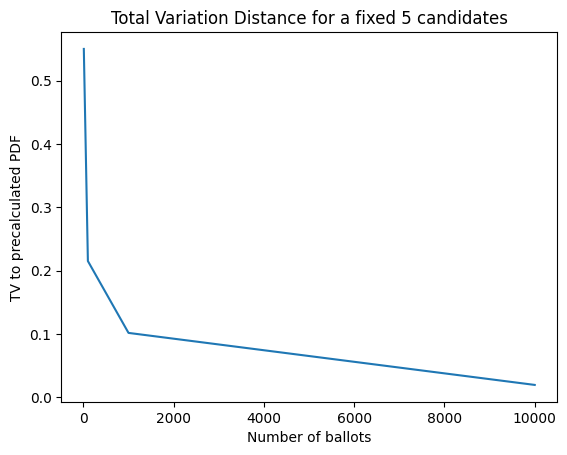

In [22]:
plt.plot(number_ballots, results_n_cands_5)
plt.xlabel("Number of ballots")
plt.ylabel("TV to precalculated PDF")
plt.title(f"Total Variation Distance for a fixed {n_cands} candidates")
plt.show()

In [24]:
number_ballots = [10, 100, 1000]#, 10000]
n_cands = 5 
num_trials = 100
SPACING_LENGTH = 100

results_n_cands_5 = np.empty((len(number_ballots)))
for i in tqdm(range(len(number_ballots))):
    results_n_cands_5[i] = tv_per_experiment(number_ballots[i], n_cands, num_trials)

100%|█████████████████████████████████████████████| 3/3 [03:22<00:00, 67.39s/it]


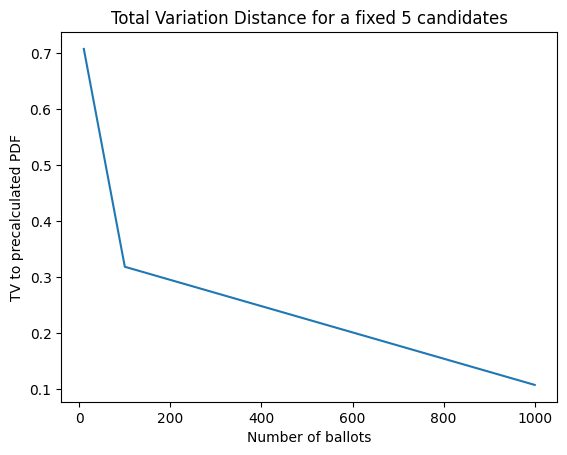

In [25]:
plt.plot(number_ballots, results_n_cands_5)
plt.xlabel("Number of ballots")
plt.ylabel("TV to precalculated PDF")
plt.title(f"Total Variation Distance for a fixed {n_cands} candidates")
plt.show()

In [39]:
num_ballots = 1000
n_cands = 5 
num_trials = 100
number_ballots = [10, 100, 1000]#, 10000]
number_candidates = [i for i in range(3,12)]
SPACING_LENGTH = 10

results_exp_2 = np.empty((len(number_ballots), len(number_candidates)))

for i in range(len(number_ballots)):
    for j in tqdm(range(len(number_candidates))):
        results_exp_2[i][j] = tv_per_experiment(number_ballots[i], number_candidates[j], num_trials)

100%|██████████████████████████████████████████| 9/9 [1:18:27<00:00, 523.07s/it]


In [45]:
number_ballots

[10, 100, 1000]

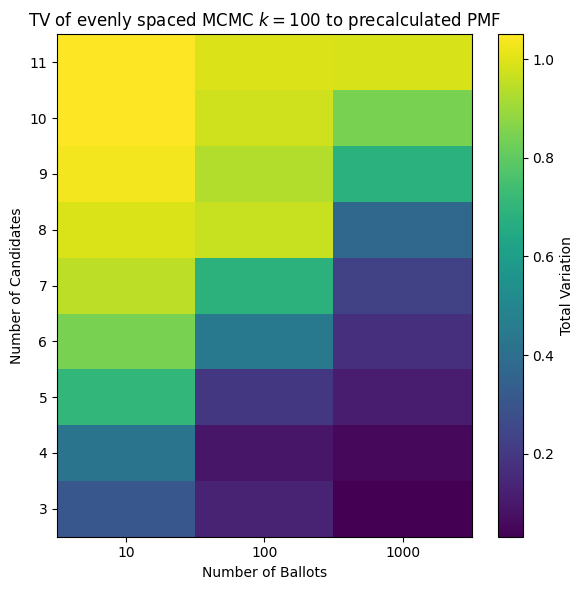

In [50]:
# Plot
plt.figure(figsize=(6, 6))
im = plt.imshow(results_exp_2.T, cmap='viridis', aspect='auto')

# Tick labels
plt.xticks(ticks=np.arange(len(number_ballots)), labels=number_ballots)
plt.yticks(ticks=np.arange(len(number_candidates)), labels=number_candidates)

plt.gca().invert_yaxis() # Invert y-axis

# Axis labels
plt.xlabel("Number of Ballots")
plt.ylabel("Number of Candidates")
plt.title(r"TV of evenly spaced MCMC $k=100$ to precalculated PMF")

# Add colorbar
plt.colorbar(im, label='Total Variation')

plt.tight_layout()
plt.show()

In [43]:
results_exp_2.T

array([[0.308  , 0.1288 , 0.03216],
       [0.424  , 0.0951 , 0.05601],
       [0.708  , 0.196  , 0.10797],
       [0.844  , 0.4452 , 0.16762],
       [0.949  , 0.6859 , 0.22709],
       [0.994  , 0.9644 , 0.37123],
       [1.032  , 0.9336 , 0.68214],
       [1.048  , 0.9748 , 0.84685],
       [1.05   , 0.9971 , 0.98794]])

TypeError: list indices must be integers or slices, not tuple

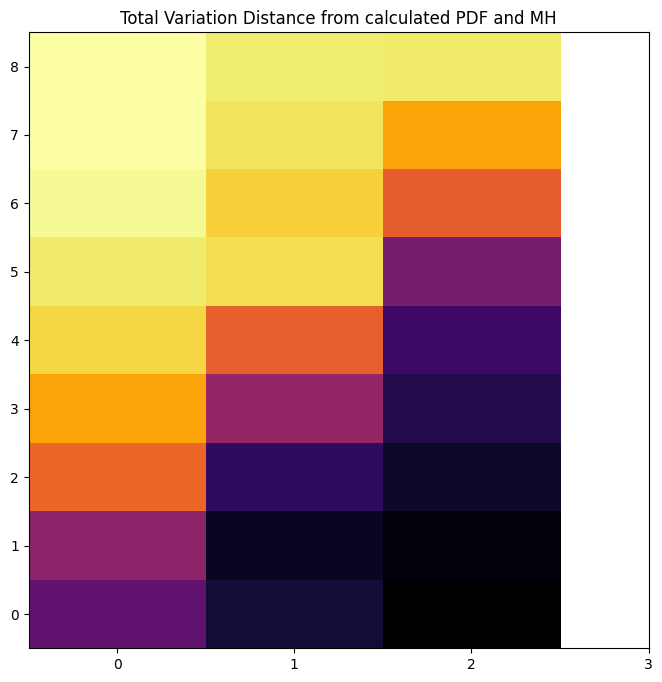

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(results_exp_2.T, origin="lower", cmap="inferno", aspect='auto')  # stretch to fill
plt.title("Total Variation Distance from calculated PDF and MH")

# What are the contour lines actually doing here? Are they partitioning where the values cross?
# Contour
ax.clabel(contours, inline=True, fontsize=10, fmt='%.1f')

num_ballots_array = np.linspace(100, 2500, 25)
num_ballots_array = num_ballots_array.astype(int)

voter_prop = np.linspace(1, 0.1, 10)

# ax.set_yticks([0, 1, 2, 3])
# ax.set_yticklabels(np.round(number_ballots[[0, 1, 2, 3]], 1))
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(number_ballots[[0,1,2,3], 1])

ax.set_ylabel("Majority Bloc Proportion")
ax.set_xlabel("Number of Ballots")
plt.colorbar()
plt.show()

TypeError: list indices must be integers or slices, not tuple

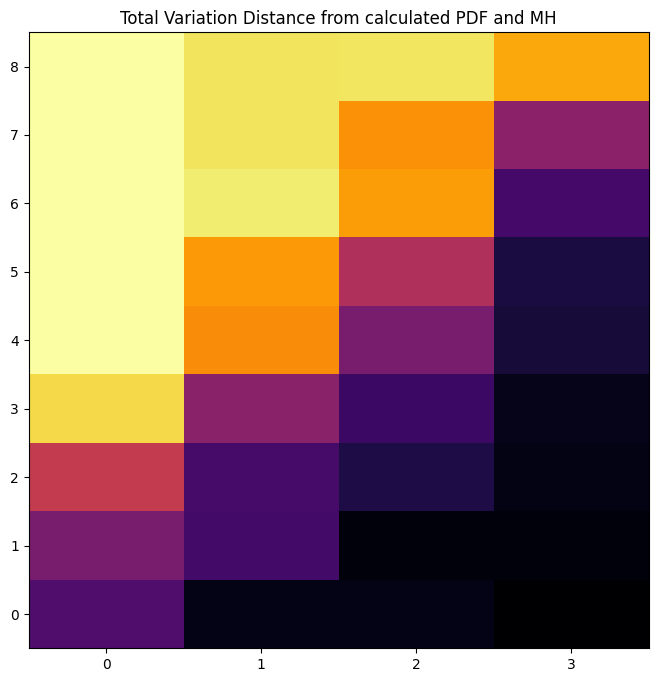

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(results.T, origin="lower", cmap="inferno", aspect='auto')  # stretch to fill
plt.title("Total Variation Distance from calculated PDF and MH")

# What are the contour lines actually doing here? Are they partitioning where the values cross?
# Contour
ax.clabel(contours, inline=True, fontsize=10, fmt='%.1f')

num_ballots_array = np.linspace(100, 2500, 25)
num_ballots_array = num_ballots_array.astype(int)

voter_prop = np.linspace(1, 0.1, 10)

# ax.set_yticks([0, 1, 2, 3])
# ax.set_yticklabels(np.round(number_ballots[[0, 1, 2, 3]], 1))
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(number_ballots[[0,1,2,3], 1])

ax.set_ylabel("Majority Bloc Proportion")
ax.set_xlabel("Number of Ballots")
plt.colorbar()
plt.show()

In [31]:
results

array([[0.25   , 0.35   , 0.55   , 0.95   , 1.05   , 1.05   , 1.05   ,
        1.05   , 1.05   ],
       [0.045  , 0.215  , 0.225  , 0.395  , 0.785  , 0.815  , 0.995  ,
        0.975  , 0.975  ],
       [0.0435 , 0.0235 , 0.1275 , 0.1955 , 0.3515 , 0.4905 , 0.8235 ,
        0.7965 , 0.9795 ],
       [0.00185, 0.02625, 0.04195, 0.04955, 0.10765, 0.11705, 0.22045,
        0.40145, 0.84875]])

In [ ]:
results_n_cands_5 = np.empty((len(number_ballots)))
for i in tqdm(range(len(number_ballots))):
    results_n_cands_5[i] = tv_per_experiment(number_ballots[i], n_cands, num_trials)

In [14]:
tv_per_experiment(num_ballots, n_cands, num_trials)

np.float64(0.1555000000000001)

In [15]:
results = np.empty((len(number_ballots), len(number_candidates)))

for i in tqdm(range(len(number_ballots))):
    for j in range(len(number_candidates)):
        results[i][j] = tv_per_experiment(number_ballots[i], number_candidates[j], num_trials)

TypeError: len() takes exactly one argument (2 given)